## Data ingestion
1. Load Data
2. Select classes to predict

## Exploratory Data Analysis -
1. Convert target label to multinomial class
2. Data Summary: Statistical description i.e. mean, std dev etc.

## Feature Engineering
1. Data Cleaning - Drop minuscule features 
2. Detect Outliers and remove
    2.i - Data Imputation for features which are mostly 0 (30% are non-zero) so filling 0's as mean 
3. Vectorize the features
4. Standrize the features
5. Train-test split
6. Handle Class imbalance
7. Visualize histogram for data spread, correlation among variates
6. Feature Selection - Correlation and chi-squared

## Model Building
## Model Evaluation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.ml.stat import Correlation
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
#from pyspark.sql.functions import *
import pyspark.sql.functions as f

In [2]:
sc.stop()

NameError: name 'sc' is not defined

In [3]:
# Initializing a Spark session
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

### 1.1 Data Ingestion

In [4]:
raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r"sulbha.ss.csv")
raw_data.columns

['AnonPuid',
 'Product_new_group_update',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music']

- Product_new_group_update = Target Group
- tot_cnt =  # of visits
- PI_... = Page impression, share of among all product cateory visit
- total_usage_engagement = time spent of site
- Usage_ ... = time spent on that product

In [5]:
raw_data.printSchema()

root
 |-- AnonPuid: integer (nullable = true)
 |-- Product_new_group_update: string (nullable = true)
 |-- tot_cnt: integer (nullable = true)
 |-- PI_Others: double (nullable = true)
 |-- PI_Productivity_App: double (nullable = true)
 |-- PI_Entertainment_App: double (nullable = true)
 |-- PI_Casual_game: double (nullable = true)
 |-- PI_Core_game: double (nullable = true)
 |-- PI_Others_OperatingSystem: double (nullable = true)
 |-- PI_Others_Pass: double (nullable = true)
 |-- PI_MMTV: double (nullable = true)
 |-- PI_Other_App: double (nullable = true)
 |-- PI_Others_Device: double (nullable = true)
 |-- PI_Others_Bundle: double (nullable = true)
 |-- PI_Others_Music: integer (nullable = true)
 |-- tot_Usage_Engagement: integer (nullable = true)
 |-- Usage_Others: integer (nullable = true)
 |-- Usage_Productivity_App: integer (nullable = true)
 |-- Usage_Entertainment_App: integer (nullable = true)
 |-- Usage_Casual_game: integer (nullable = true)
 |-- Usage_Core_game: integer (null

In [6]:
pd.DataFrame(raw_data.take(5), columns = raw_data.columns).transpose()

0          1                 2  \
AnonPuid                           1          2                 3   
Product_new_group_update      Others     Others  Productivity_App   
tot_cnt                            3          1                 1   
PI_Others                          1          1                 0   
PI_Productivity_App                0          0                 1   
PI_Entertainment_App               0          0                 0   
PI_Casual_game                     0          0                 0   
PI_Core_game                       0          0                 0   
PI_Others_OperatingSystem          0          0                 0   
PI_Others_Pass                     0          0                 0   
PI_MMTV                            0          0                 0   
PI_Other_App                       0          0                 0   
PI_Others_Device                   0          0                 0   
PI_Others_Bundle                   0          0                 0   
PI_Others_Music                    0          0                 0   
tot_Usage_Engagement            3375  300027096           1558297   
Usage_Others                       0          0                 0   
Usage_Productivity_App             0    7268661            370781   
Usage_Entertainment_App         3375       9984           1187516   
Usage_Casual_game                  0  292642266                 0   
Usage_Core_game                    0          0                 0   
Usage_Others_OperatingSystem       0          0                 0   
Usage_Others_Pass                  0          0                 0   
Usage_MMTV                         0     106185                 0   
Usage_Other_App                    0          0                 0   
Usage_Others_Device                0          0                 0   
Usage_Others_Bundle                0          0                 0   
Usage_Others_Music                 0          0                 0   

                                              3         4  
AnonPuid                                      4         5  
Product_new_group_update      Entertainment_App    Others  
tot_cnt                                      13        18  
PI_Others                              0.923077       0.5  
PI_Productivity_App                    0.384615  0.222222  
PI_Entertainment_App                   0.461538         0  
PI_Casual_game                         0.230769         0  
PI_Core_game                                  0  0.277778  
PI_Others_OperatingSystem                     0         0  
PI_Others_Pass                                0         0  
PI_MMTV                                       0         0  
PI_Other_App                                  0         0  
PI_Others_Device                              0         0  
PI_Others_Bundle                              0         0  
PI_Others_Music                               0         0  
tot_Usage_Engagement                   46524503    589592  
Usage_Others                                  0         0  
Usage_Productivity_App                 11070747    587733  
Usage_Entertainment_App                12021833      1859  
Usage_Casual_game                          9609         0  
Usage_Core_game                               0         0  
Usage_Others_OperatingSystem                  0         0  
Usage_Others_Pass                             0         0  
Usage_MMTV                             23422314         0  
Usage_Other_App                               0         0  
Usage_Others_Device                           0         0  
Usage_Others_Bundle                           0         0  
Usage_Others_Music                            0         0

In [7]:
raw_data.groupBy("Product_new_group_update").count().toPandas()

Product_new_group_update  count
0         Productivity_App     45
1                     MMTV      2
2              Others_Pass      3
3              Casual_game     17
4                Core_game     14
5  Others_Operating System      3
6                   Others    279
7        Entertainment_App     29

### 1.2 Let's consider 3 classes - 'Others' , 'Productivity_App', 'Entertainment_App'

In [8]:
d = raw_data.select('*').where((raw_data.Product_new_group_update =='Productivity_App') | (raw_data.Product_new_group_update =='Others') | (raw_data.Product_new_group_update =='Entertainment_App')).collect()
data1 = spark.createDataFrame(d,raw_data.columns )

In [9]:
data1.groupBy('Product_new_group_update').count().toPandas()

Product_new_group_update  count
0         Productivity_App     45
1                   Others    279
2        Entertainment_App     29

### 2 Exploratory Data Analysis

In [10]:
data1.columns

['AnonPuid',
 'Product_new_group_update',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music']

#### 2.1 Convert target label to multinomial class

In [11]:
data2 = data1.withColumn("label_New", lit(-1))

data2 = data2\
.withColumn('label_New',when(data2['Product_new_group_update'] == 'Others',0).otherwise(data2.label_New))

data2 = data2\
.withColumn('label_New',when(data2['Product_new_group_update'] == 'Productivity_App',1).otherwise(data2.label_New))

data2 = data2\
.withColumn('label_New',when(data2['Product_new_group_update'] == 'Entertainment_App',2).otherwise(data2.label_New))

data2\
.select(col('label_New').alias('label'),col('*'))\
.toPandas().head(5)

label  AnonPuid Product_new_group_update  tot_cnt  PI_Others  \
0      0         1                   Others        3   1.000000   
1      0         2                   Others        1   1.000000   
2      1         3         Productivity_App        1   0.000000   
3      2         4        Entertainment_App       13   0.923077   
4      0         5                   Others       18   0.500000   

   PI_Productivity_App  PI_Entertainment_App  PI_Casual_game  PI_Core_game  \
0             0.000000              0.000000        0.000000      0.000000   
1             0.000000              0.000000        0.000000      0.000000   
2             1.000000              0.000000        0.000000      0.000000   
3             0.384615              0.461538        0.230769      0.000000   
4             0.222222              0.000000        0.000000      0.277778   

   PI_Others_OperatingSystem    ...      Usage_Casual_game  Usage_Core_game  \
0                        0.0    ...                      0                0   
1                        0.0    ...              292642266                0   
2                        0.0    ...                      0                0   
3                        0.0    ...                   9609                0   
4                        0.0    ...                      0                0   

   Usage_Others_OperatingSystem  Usage_Others_Pass  Usage_MMTV  \
0                             0                  0           0   
1                             0                  0      106185   
2                             0                  0           0   
3                             0                  0    23422314   
4                             0                  0           0   

   Usage_Other_App  Usage_Others_Device  Usage_Others_Bundle  \
0                0                    0                    0   
1                0                    0                    0   
2                0                    0                    0   
3                0                    0                    0   
4                0                    0                    0   

   Usage_Others_Music  label_New  
0                   0          0  
1                   0          0  
2                   0          1  
3                   0          2  
4                   0          0  

[5 rows x 30 columns]

In [12]:
# drop categorical target variable
data2 = data2.drop('Product_new_group_update')
print (data2.columns)
print (data2.toPandas().head(5))

['AnonPuid', 'tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', 'PI_Core_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', 'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others', 'Usage_Productivity_App', 'Usage_Entertainment_App', 'Usage_Casual_game', 'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_MMTV', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music', 'label_New']
   AnonPuid  tot_cnt  PI_Others  PI_Productivity_App  PI_Entertainment_App  \
0         1        3   1.000000             0.000000              0.000000   
1         2        1   1.000000             0.000000              0.000000   
2         3        1   0.000000             1.000000              0.000000   
3         4       13   0.923077             0.384615              0.461538   
4         5       18   0.500000             0.222222       

### 2.2. Find data summary

In [39]:
exclude_cols = ['AnonPuid', 'label_New']
corr_cols = [c for c in  data2.columns if c not in exclude_cols]

data_corr =  data1.select(corr_cols)
data_corr.describe().toPandas().transpose()

0                      1  \
summary                       count                   mean   
tot_cnt                         353      9.444759206798867   
PI_Others                       353     0.7737874180906517   
PI_Productivity_App             353    0.17564524852974508   
PI_Entertainment_App            353    0.16602384354107652   
PI_Casual_game                  353    0.11297854711898016   
PI_Core_game                    353     0.0654968802549575   
PI_Others_OperatingSystem       353  0.0025368562322946177   
PI_Others_Pass                  353   0.011444561512747876   
PI_MMTV                         353   0.006490084674220964   
PI_Other_App                    353   0.003309769059490085   
PI_Others_Device                353  0.0019733727167138807   
PI_Others_Bundle                353   7.128441586402265E-4   
PI_Others_Music                 353                    0.0   
tot_Usage_Engagement            353   3.0278153645892352E7   
Usage_Others                    353                    0.0   
Usage_Productivity_App          353      2887640.793201133   
Usage_Entertainment_App         353    1.578475554674221E7   
Usage_Casual_game               353      7399592.388101983   
Usage_Core_game                 353     1891054.5722379603   
Usage_Others_OperatingSystem    353                    0.0   
Usage_Others_Pass               353     1644082.9461756374   
Usage_MMTV                      353      671027.3994334277   
Usage_Other_App                 353                    0.0   
Usage_Others_Device             353                    0.0   
Usage_Others_Bundle             353                    0.0   
Usage_Others_Music              353                    0.0   

                                                 2    3            4  
summary                                     stddev  min          max  
tot_cnt                         14.326466766543549    1          161  
PI_Others                      0.30406380942832406  0.0          1.0  
PI_Productivity_App             0.2661814164952494  0.0          1.0  
PI_Entertainment_App            0.2550527491729801  0.0          1.0  
PI_Casual_game                 0.21130988820872706  0.0          1.0  
PI_Core_game                   0.15919261067517118  0.0          1.0  
PI_Others_OperatingSystem     0.030002123819534012  0.0          0.5  
PI_Others_Pass                 0.07149547116124849  0.0          1.0  
PI_MMTV                         0.0394291304013073  0.0  0.333333333  
PI_Other_App                  0.018843085701949532  0.0  0.166666667  
PI_Others_Device              0.017885962285339035  0.0         0.25  
PI_Others_Bundle              0.009467329257845365  0.0  0.166666667  
PI_Others_Music                                0.0    0            0  
tot_Usage_Engagement          1.0843569140072279E8  437   1564965047  
Usage_Others                                   0.0    0            0  
Usage_Productivity_App           8328090.365942975    0     73786670  
Usage_Entertainment_App        9.374913999593619E7    0   1495979798  
Usage_Casual_game              3.458885994179648E7    0    379321524  
Usage_Core_game               1.1972544992895395E7    0    169869164  
Usage_Others_OperatingSystem                   0.0    0            0  
Usage_Others_Pass             1.4977467826347379E7    0    259938031  
Usage_MMTV                       4864652.744976976    0     53631513  
Usage_Other_App                                0.0    0            0  
Usage_Others_Device                            0.0    0            0  
Usage_Others_Bundle                            0.0    0            0  
Usage_Others_Music                             0.0    0            0

In [ ]:
## plot data distribution

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value enco

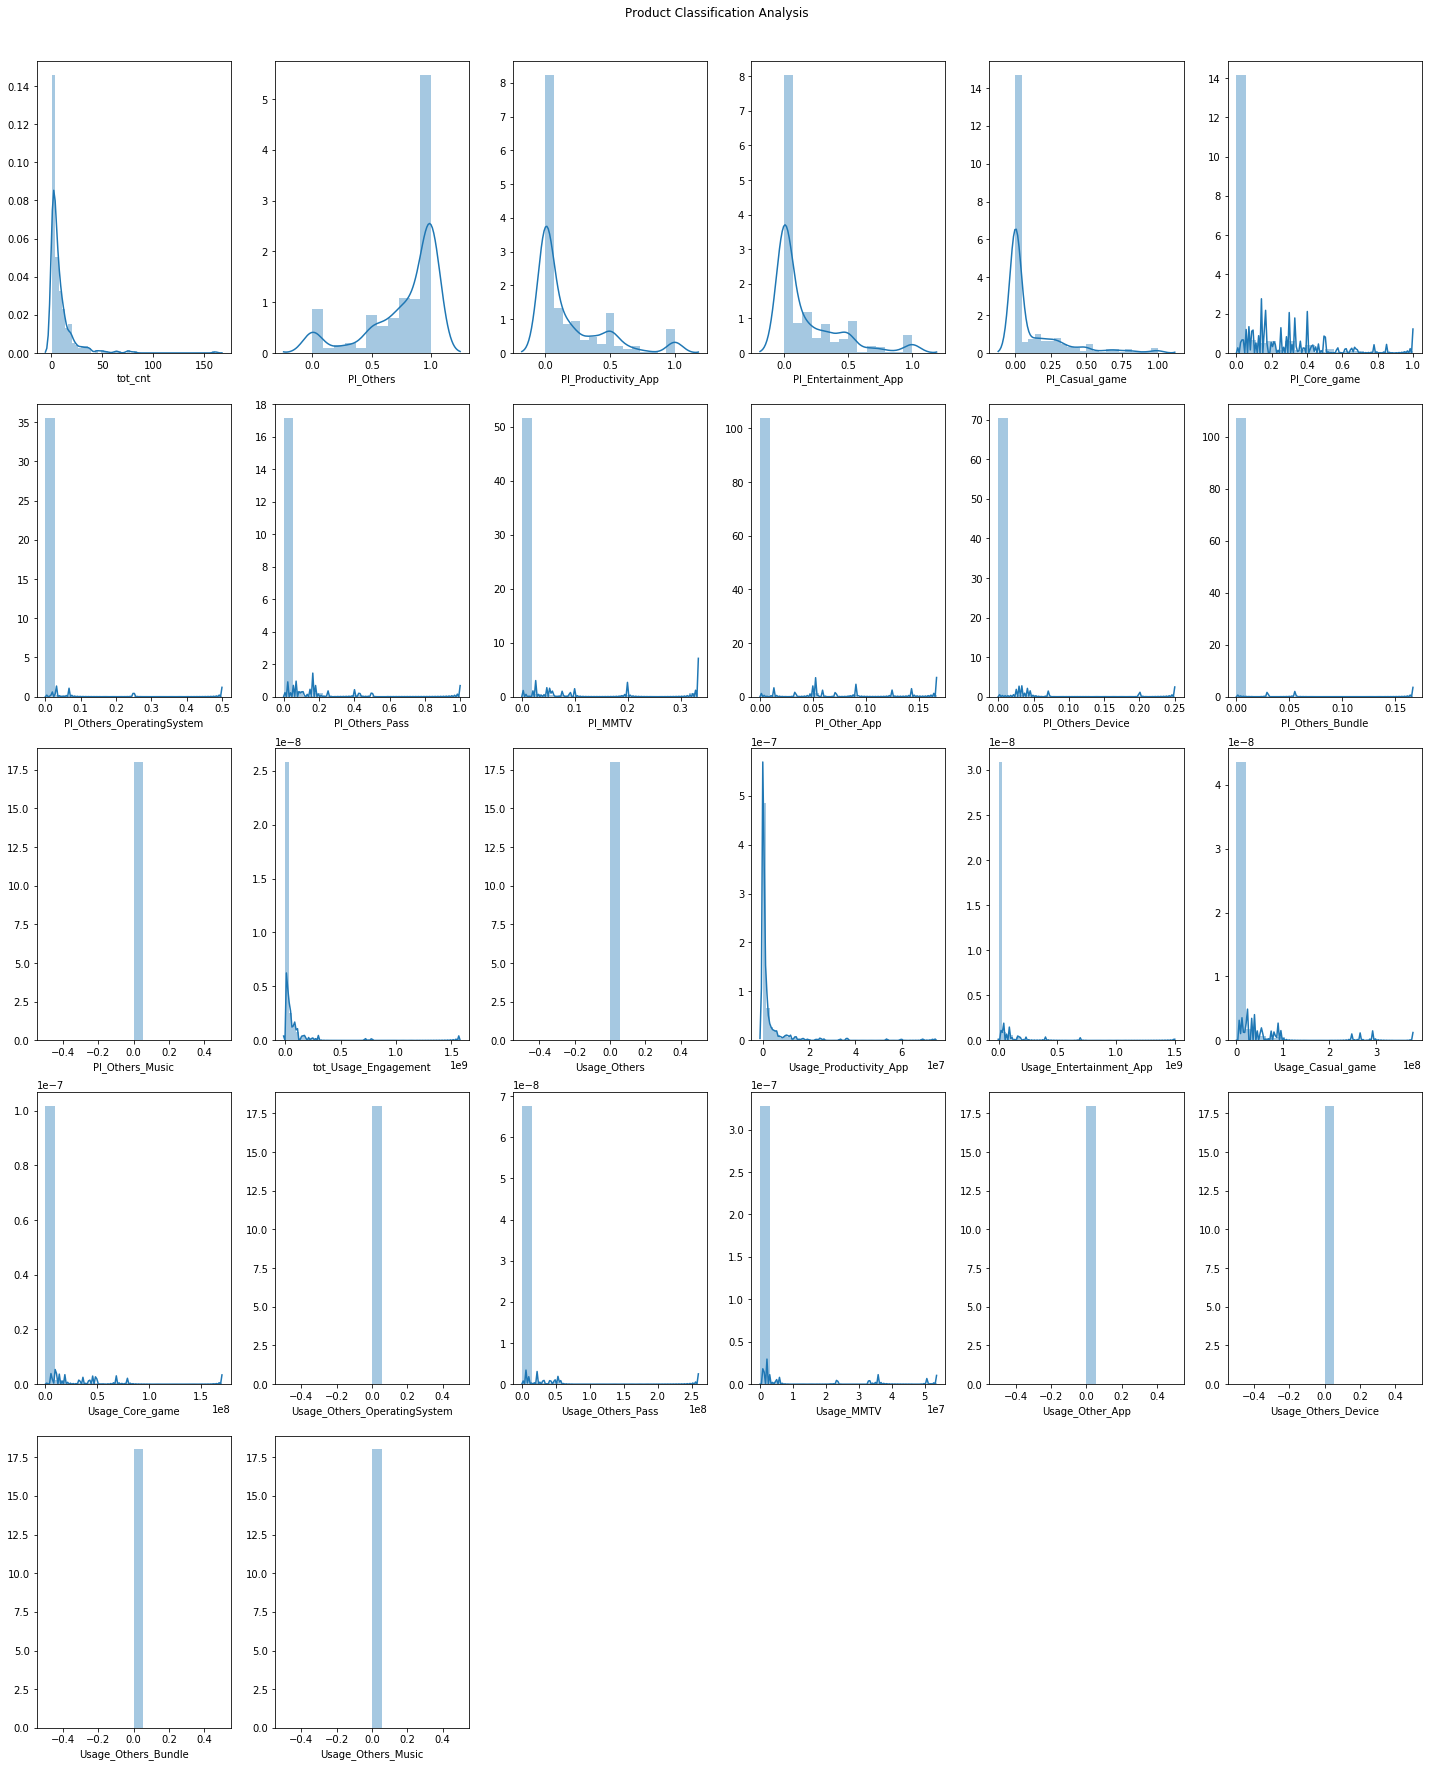

In [71]:
data_corr_numeric = data_corr.toPandas()

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_corr_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(data_corr_numeric[i])
    #plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### 3. Feature Engineering

### 3.1. Data Cleaning - Drop minuscule features 

In [14]:
# below features had 0 values so lets drop them
drop_cols = ['Usage_Others', 'Usage_Others_OperatingSystem', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle',\
             'Usage_Others_Music','PI_Others_Music']
data_corr = data_corr.select([c for c in data_corr.columns if c not in drop_cols])
data_corr.columns

['tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'tot_Usage_Engagement',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_Pass',
 'Usage_MMTV']

### 3.2 Log transformation  - As data is right skewed so apply log transformation to features

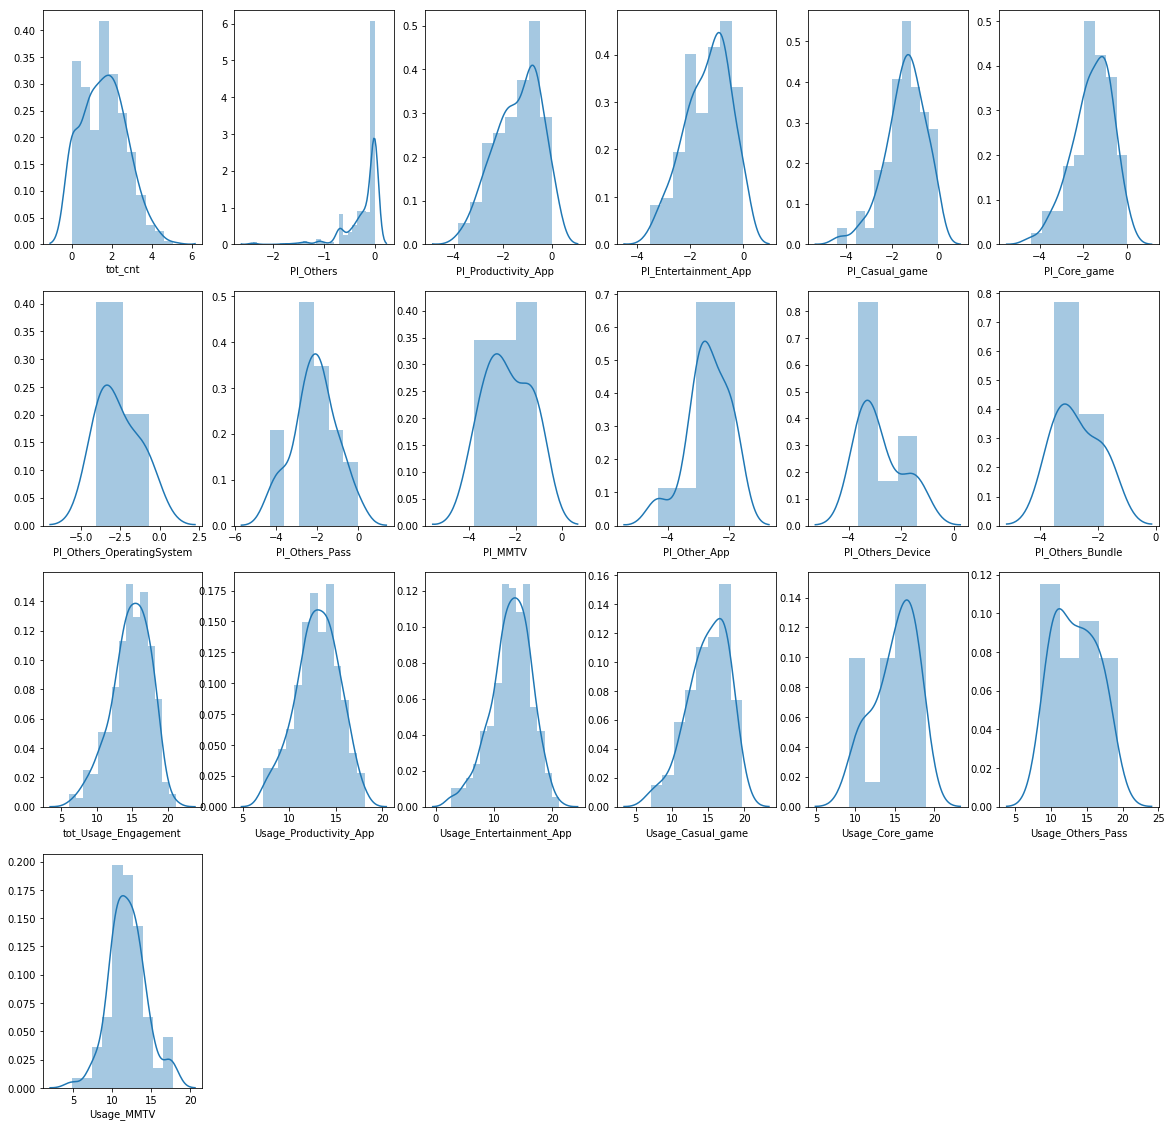

In [38]:
## test 
fig = plt.figure(figsize = (20, 25))
j = 0

for c in data_corr_numeric.columns:
    #print ((c))
    t1= data_corr_numeric[data_corr_numeric[c]!=0][c]
    t = np.log(t1)
    

    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(t)
    

In [ ]:
# data looks much better now

### 3.2. Detect Outliers and removal

In [66]:
d= {}
for col in data_corr.columns:
    
    d[col] = data_corr.approxQuantile(col,[0.25,0.75],0)
    print(col+" done")


tot_cnt
tot_cnt done
PI_Others
PI_Others done
PI_Productivity_App
PI_Productivity_App done
PI_Entertainment_App
PI_Entertainment_App done
PI_Casual_game
PI_Casual_game done
PI_Core_game
PI_Core_game done
PI_Others_OperatingSystem
PI_Others_OperatingSystem done
PI_Others_Pass
PI_Others_Pass done
PI_MMTV
PI_MMTV done
PI_Other_App
PI_Other_App done
PI_Others_Device
PI_Others_Device done
PI_Others_Bundle
PI_Others_Bundle done
PI_Others_Music
PI_Others_Music done
tot_Usage_Engagement
tot_Usage_Engagement done
Usage_Others
Usage_Others done
Usage_Productivity_App
Usage_Productivity_App done
Usage_Entertainment_App
Usage_Entertainment_App done
Usage_Casual_game
Usage_Casual_game done
Usage_Core_game
Usage_Core_game done
Usage_Others_OperatingSystem
Usage_Others_OperatingSystem done
Usage_Others_Pass
Usage_Others_Pass done
Usage_MMTV
Usage_MMTV done
Usage_Other_App
Usage_Other_App done
Usage_Others_Device
Usage_Others_Device done
Usage_Others_Bundle
Usage_Others_Bundle done
Usage_Others_Music


In [67]:
d

{'tot_cnt': [2.0, 11.0],
 'PI_Others': [0.666666667, 1.0],
 'PI_Productivity_App': [0.0, 0.25],
 'PI_Entertainment_App': [0.0, 0.258064516],
 'PI_Casual_game': [0.0, 0.166666667],
 'PI_Core_game': [0.0, 0.0],
 'PI_Others_OperatingSystem': [0.0, 0.0],
 'PI_Others_Pass': [0.0, 0.0],
 'PI_MMTV': [0.0, 0.0],
 'PI_Other_App': [0.0, 0.0],
 'PI_Others_Device': [0.0, 0.0],
 'PI_Others_Bundle': [0.0, 0.0],
 'PI_Others_Music': [0.0, 0.0],
 'tot_Usage_Engagement': [512348.0, 19389657.0],
 'Usage_Others': [0.0, 0.0],
 'Usage_Productivity_App': [26859.0, 1723815.0],
 'Usage_Entertainment_App': [9423.0, 3497328.0],
 'Usage_Casual_game': [0.0, 0.0],
 'Usage_Core_game': [0.0, 0.0],
 'Usage_Others_OperatingSystem': [0.0, 0.0],
 'Usage_Others_Pass': [0.0, 0.0],
 'Usage_MMTV': [0.0, 0.0],
 'Usage_Other_App': [0.0, 0.0],
 'Usage_Others_Device': [0.0, 0.0],
 'Usage_Others_Bundle': [0.0, 0.0],
 'Usage_Others_Music': [0.0, 0.0]}

In [ ]:
df_corr = data_corr.withColumn(col,f.log(f.when(data_corr[col] < d[col][0],d[col][0])\
    .when(data_corr[col] > d[col][1], d[col][1])\
     .otherwise(data_corr[col])+1))

In [112]:
data3 = df_corr.withColumn("tot_cnt"+"_New", lit(-1))

data3 = data3\
.withColumn("tot_cnt"+"_New",f.log(f.when(data_corr["tot_cnt"] < d["tot_cnt"][0],d["tot_cnt"][0])\
    .when(data_corr["tot_cnt"] > d["tot_cnt"][1], d["tot_cnt"][1])\
     .otherwise(data_corr["tot_cnt"])+1))


In [114]:
data3 = data3.withColumn("PI_Others"+"_New", lit(-1))

data3 = data3\
.withColumn("PI_Others"+"_New",f.log(f.when(data_corr["PI_Others"] < d["PI_Others"][0],d["PI_Others"][0])\
    .when(data_corr["PI_Others"] > d["PI_Others"][1], d["PI_Others"][1])\
     .otherwise(data_corr["PI_Others"])+1))

In [116]:
for col in data_corr.columns:
    data_corr = data_corr.withColumn(col +"_New", lit(-1))

    data_corr = data_corr\
    .withColumn(col +"_New",f.log(f.when(data_corr[col] < d[col][0],d[col][0])\
        .when(data_corr[col] > d[col][1], d[col][1])\
         .otherwise(data_corr[col])+1))

In [124]:
# # looping through the columns, doing log(x+1) transformations
# for col in data_corr.columns:
# #     df_new = data_corr.withColumn(col, \
# #     f.log(f.when(data_corr[col] < d[col][0],d[col][0])\
# #     .when(data_corr[col] > d[col][1], d[col][1])\
# #     .otherwise(data_corr[col])+1).alias(col))
# #     print (data_corr.select(col).first(), d[col][0], d[col][1])
#     #df_new = data_corr.select(f.log(data_corr[col]+1).alias(col))
#     df_corr = data_corr.withColumn(col,f.log(f.when(data_corr[col] < d[col][0],d[col][0])\
#     .when(data_corr[col] > d[col][1], d[col][1])\
#      .otherwise(data_corr[col])+1))
#     print (df_corr.first())
#     #print (data_corr.select(f.log(data_corr[col]+1).alias(col)).first())
# #   print (data_corr.select(col).first(), d[col][0], d[col][1])

# #     print (data_corr.select(col))
# #     print(col+" done")

In [128]:
cols_new = [c for c in data_corr.columns if c.endswith('_New')]
data_corr_numeric = data_corr.select(cols_new).toPandas()

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value enco

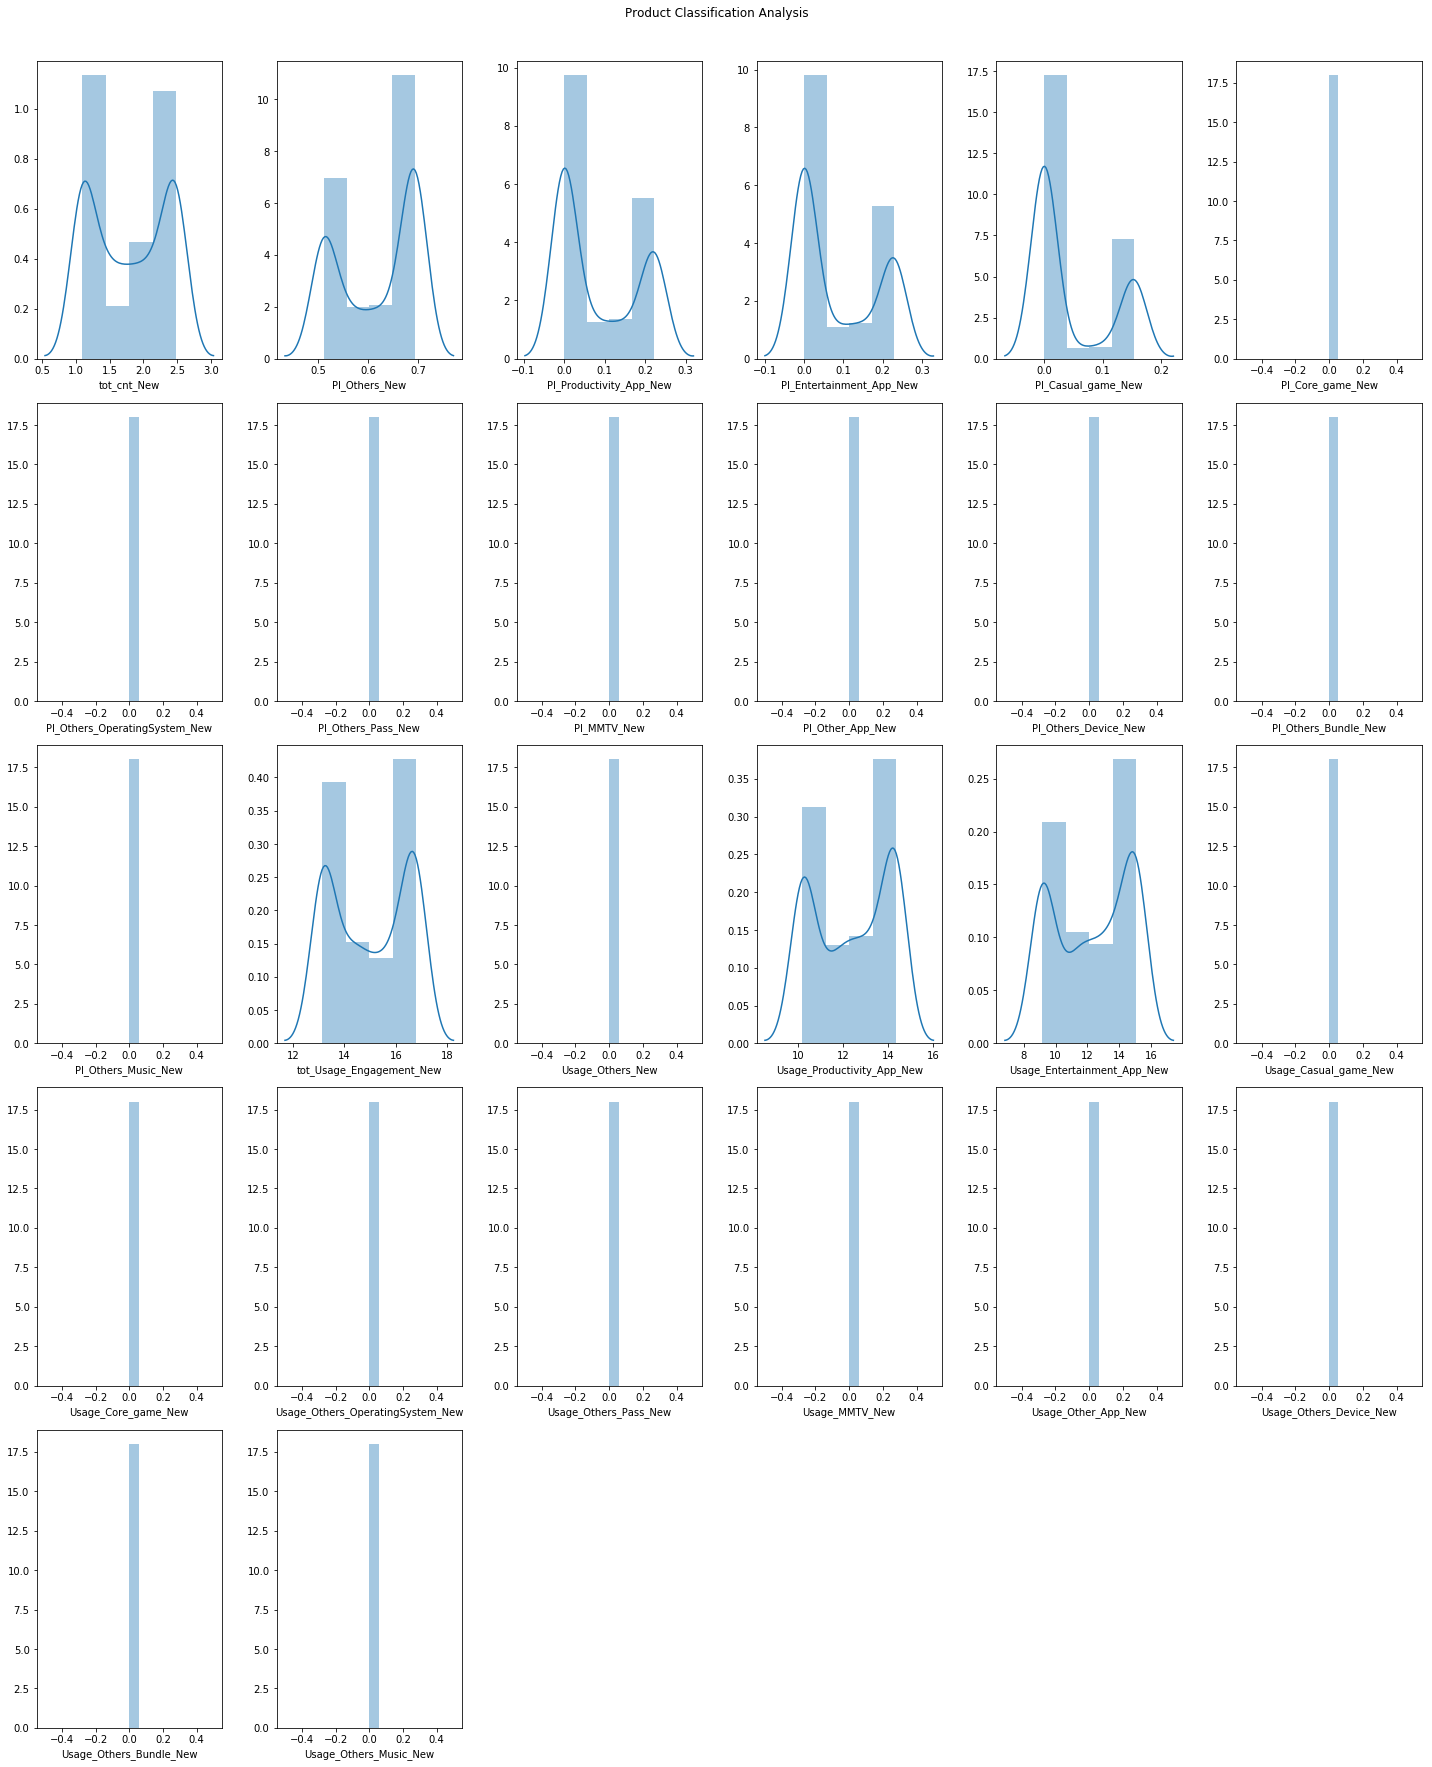

In [129]:
#data_corr_numeric = df_corr.select(cols_new).toPandas()

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_corr_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(data_corr_numeric[i])
    #plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [73]:
## check outliers based on IQR distance
bounds = {
    c: dict(
        zip(["q1", "q3"], data_corr.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in data_corr.columns
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
print(bounds)

{'tot_cnt': {'q1': 2.0, 'q3': 11.0, 'lower': -11.5, 'upper': 24.5}, 'PI_Others': {'q1': 0.666666667, 'q3': 1.0, 'lower': 0.16666666749999998, 'upper': 1.4999999995}, 'PI_Productivity_App': {'q1': 0.0, 'q3': 0.25, 'lower': -0.375, 'upper': 0.625}, 'PI_Entertainment_App': {'q1': 0.0, 'q3': 0.258064516, 'lower': -0.38709677400000003, 'upper': 0.6451612900000001}, 'PI_Casual_game': {'q1': 0.0, 'q3': 0.166666667, 'lower': -0.2500000005, 'upper': 0.4166666675}, 'PI_Core_game': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_OperatingSystem': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_Pass': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_MMTV': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Other_App': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_Device': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_Bundle': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'tot_Usage_Engagement': {'q1': 512348.0, 'q3':

In [231]:
# Mark rows within 1 IQR + 3IQR as 0(No-Outlier) else 1(Outlier). New features ending with '_out' are created. 
data_outlier = data2.select(
    "*",
    *[
        f.when(
            f.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in data_corr.columns
    ]
)
data_outlier.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'tot_cnt_out',
 'PI_Others_out',
 'PI_Productivity_App_out',
 'PI_Entertainment_App_out',
 'PI_Casual_game_out',
 'PI_Core_game_out',
 'PI_Others_OperatingSystem_out',
 'PI_Others_Pass_out',
 'PI_MMTV_out',
 'PI_Other_App_out',
 'PI_Others_Device_out',
 'PI_Others_Bundle_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Core_game_out',
 

In [232]:
# explore how many rows have outliered data. < 5%
out_lst = []
for i in data_outlier.columns:
    if i.endswith('_out'):
        percent_outlier= ((data_outlier.filter(data_outlier[i]==1).count())*100/(data_outlier.count()))
        #print (data_outlier.count())
        print (i + ' has ' + str(percent_outlier) )
        if percent_outlier <5:
            out_lst.append(i[:-4])
       
out_lst

tot_cnt_out has 7.648725212464589
PI_Others_out has 8.78186968838527
PI_Productivity_App_out has 6.798866855524079
PI_Entertainment_App_out has 6.798866855524079
PI_Casual_game_out has 9.63172804532578
PI_Core_game_out has 23.229461756373937
PI_Others_OperatingSystem_out has 1.6997167138810199
PI_Others_Pass_out has 5.665722379603399
PI_MMTV_out has 4.53257790368272
PI_Other_App_out has 3.9660056657223794
PI_Others_Device_out has 2.26628895184136
PI_Others_Bundle_out has 0.8498583569405099
tot_Usage_Engagement_out has 13.881019830028329
Usage_Productivity_App_out has 14.73087818696884
Usage_Entertainment_App_out has 15.297450424929178
Usage_Casual_game_out has 24.362606232294617
Usage_Core_game_out has 8.78186968838527
Usage_Others_Pass_out has 10.76487252124646
Usage_MMTV_out has 24.362606232294617


['PI_Others_OperatingSystem',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle']

In [233]:
data_outlier.count()

353

In [234]:
# some features have lots of outliers > 10%, which might result in data loss so do not drop .. instead impute with mean value   
#do_not_drop_outlier= ['PI_Core_game_out','Usage_Casual_game_out','Usage_MMTV_out']
#expr = ' and '.join('(%s == 0)' % col_name for col_name in out_lst if col_name not in do_not_drop_outlier)
expr = ' and '.join('(%s_out == 0)' % col_name for col_name in out_lst)

expr

'(PI_Others_OperatingSystem_out == 0) and (PI_MMTV_out == 0) and (PI_Other_App_out == 0) and (PI_Others_Device_out == 0) and (PI_Others_Bundle_out == 0)'

In [235]:
data_outlier.filter(expr).count()

313

In [236]:
data_outlier.count()

353

In [237]:
199/353

0.5637393767705382

In [238]:
data_outlier = data_outlier.filter(expr)
data_outlier.count()

313

In [239]:
data_outlier.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'tot_cnt_out',
 'PI_Others_out',
 'PI_Productivity_App_out',
 'PI_Entertainment_App_out',
 'PI_Casual_game_out',
 'PI_Core_game_out',
 'PI_Others_OperatingSystem_out',
 'PI_Others_Pass_out',
 'PI_MMTV_out',
 'PI_Other_App_out',
 'PI_Others_Device_out',
 'PI_Others_Bundle_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Core_game_out',
 

## 2.2.i Data Imputation

In [240]:
impute_cols = [c for c in data_outlier.columns if c.endswith('_out') and c[:-4] not in out_lst]

#data2 = data2\
#.withColumn('label_New',when(data2['Product_new_group_update'] == 'Others',0).otherwise(data2.label_New))
data_impute = data_outlier

In [241]:
impute_cols

['tot_cnt_out',
 'PI_Others_out',
 'PI_Productivity_App_out',
 'PI_Entertainment_App_out',
 'PI_Casual_game_out',
 'PI_Core_game_out',
 'PI_Others_Pass_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Core_game_out',
 'Usage_Others_Pass_out',
 'Usage_MMTV_out']

In [242]:
for c in impute_cols:
    df_new = data_impute.withColumn(c,log(data_impute[c]).alias(c))
    print(c+" done")

tot_cnt_out done
PI_Others_out done
PI_Productivity_App_out done
PI_Entertainment_App_out done
PI_Casual_game_out done
PI_Core_game_out done
PI_Others_Pass_out done
tot_Usage_Engagement_out done
Usage_Productivity_App_out done
Usage_Entertainment_App_out done
Usage_Casual_game_out done
Usage_Core_game_out done
Usage_Others_Pass_out done
Usage_MMTV_out done


C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


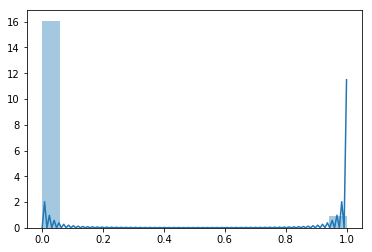

In [248]:
sns.distplot(data_impute.select('tot_cnt_out').toPandas())

In [254]:
ddd = data_impute.select('tot_cnt_out').toPandas().fillna(0)

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


ValueError: cannot convert float NaN to integer

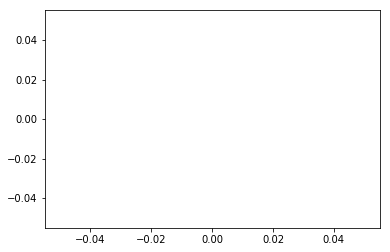

In [257]:
sns.distplot(np.log(ddd))

In [245]:
df_new.toPandas().head()

AnonPuid  tot_cnt  PI_Others  PI_Productivity_App  PI_Entertainment_App  \
0         1        3   1.000000             0.000000              0.000000   
1         2        1   1.000000             0.000000              0.000000   
2         3        1   0.000000             1.000000              0.000000   
3         4       13   0.923077             0.384615              0.461538   
4         5       18   0.500000             0.222222              0.000000   

   PI_Casual_game  PI_Core_game  PI_Others_OperatingSystem  PI_Others_Pass  \
0        0.000000      0.000000                        0.0             0.0   
1        0.000000      0.000000                        0.0             0.0   
2        0.000000      0.000000                        0.0             0.0   
3        0.230769      0.000000                        0.0             0.0   
4        0.000000      0.277778                        0.0             0.0   

   PI_MMTV       ...        PI_Other_App_out  PI_Others_Device_out  \
0      0.0       ...                       0                     0   
1      0.0       ...                       0                     0   
2      0.0       ...                       0                     0   
3      0.0       ...                       0                     0   
4      0.0       ...                       0                     0   

   PI_Others_Bundle_out  tot_Usage_Engagement_out  Usage_Productivity_App_out  \
0                     0                         0                           0   
1                     0                         1                           1   
2                     0                         0                           0   
3                     0                         0                           1   
4                     0                         0                           0   

   Usage_Entertainment_App_out  Usage_Casual_game_out  Usage_Core_game_out  \
0                            0                      0                    0   
1                            0                      1                    0   
2                            0                      0                    0   
3                            1                      1                    0   
4                            0                      0                    0   

   Usage_Others_Pass_out  Usage_MMTV_out  
0                      0             NaN  
1                      0             0.0  
2                      0             NaN  
3                      0             0.0  
4                      0             NaN  

[5 rows x 47 columns]

In [180]:
#impute_cols = ['PI_Core_game','Usage_Casual_game','Usage_MMTV']



for c in impute_cols:
    expr = c+'==1'
    col_name = c[:-4]
    #print (expr, col_name)
    mean_val = data_impute.select(col_name).filter(expr).agg(avg(col_name)).first()[0]
    data_impute = data_impute.withColumn(col_name+"_impute", lit(-1))
    data_impute = data_impute \
         .withColumn(col_name+"_impute", when(data_impute[c]==0, mean_val).otherwise(data2[col_name]))

data_impute.describe().toPandas()        

summary            AnonPuid             tot_cnt            PI_Others  \
0   count                 199                 199                  199   
1    mean  191.02010050251258  5.8040201005025125    0.867333718246231   
2  stddev  113.94518262934284   4.905859609145417  0.19804389485068646   
3     min                   1                   1                  0.2   
4     max                 391                  23                  1.0   

   PI_Productivity_App PI_Entertainment_App       PI_Casual_game  \
0                  199                  199                  199   
1  0.11738009954271357  0.11115610739195982  0.04692357209547737   
2  0.18045307416975784   0.1703562441905724  0.10008924774092137   
3                  0.0                  0.0                  0.0   
4                  0.6                0.625                  0.4   

          PI_Core_game PI_Others_OperatingSystem PI_Others_Pass  \
0                  199                       199            199   
1  0.05004665592964824                       0.0            0.0   
2  0.14558428864120943                       0.0            0.0   
3                  0.0                       0.0            0.0   
4                  1.0                       0.0            0.0   

          ...         Usage_Core_game_out Usage_Others_Pass_out  \
0         ...                         199                   199   
1         ...                         0.0   0.10552763819095477   
2         ...                         0.0    0.3080069492688908   
3         ...                           0                     0   
4         ...                           0                     1   

        Usage_MMTV_out  PI_Core_game_impute tot_Usage_Engagement_impute  \
0                  199                  199                         199   
1  0.23115577889447236  0.33197615099999966         1.726893485909088E8   
2     0.42263503711864  0.08374900544653548         6.501245881539839E7   
3                    0          0.043478261                 5.1085733E7   
4                    1                  1.0                 7.8132147E8   

  Usage_Productivity_App_impute Usage_Entertainment_App_impute  \
0                           199                            199   
1          1.3869898724137923E7                   8.23358315E7   
2             4619910.438832001            5.423301731576796E7   
3                     4535768.0                      8913486.0   
4                   5.9731427E7                   6.96835615E8   

  Usage_Casual_game_impute Usage_Others_Pass_impute   Usage_MMTV_impute  
0                      199                      199                 199  
1     3.1745382567567594E7     2.1507374380952362E7  3375206.2826087032  
2      3.322659362419482E7       1.81883648573929E7   5301774.761739316  
3                   1188.0                  17686.0              1500.0  
4             3.79321524E8             2.59938031E8         5.3631513E7  

[5 rows x 55 columns]

In [181]:
data_impute.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'tot_cnt_out',
 'PI_Others_out',
 'PI_Productivity_App_out',
 'PI_Entertainment_App_out',
 'PI_Casual_game_out',
 'PI_Core_game_out',
 'PI_Others_OperatingSystem_out',
 'PI_Others_Pass_out',
 'PI_MMTV_out',
 'PI_Other_App_out',
 'PI_Others_Device_out',
 'PI_Others_Bundle_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Core_game_out',
 

In [182]:
impute_cols

['PI_Core_game_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Others_Pass_out',
 'Usage_MMTV_out']

In [185]:
final_cols = data2.columns 

for c in impute_cols:
    cc = c[:-4]
    final_cols.remove(cc)

final_cols.extend(['PI_Core_game_impute',
 'tot_Usage_Engagement_impute',
 'Usage_Productivity_App_impute',
 'Usage_Entertainment_App_impute',
 'Usage_Casual_game_impute',
 'Usage_Others_Pass_impute',
 'Usage_MMTV_impute'])
final_cols

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'Usage_Others',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'PI_Core_game_impute',
 'tot_Usage_Engagement_impute',
 'Usage_Productivity_App_impute',
 'Usage_Entertainment_App_impute',
 'Usage_Casual_game_impute',
 'Usage_Others_Pass_impute',
 'Usage_MMTV_impute']

In [186]:
# keep original feature set i.e. no need of outlier columns

data_final = data_impute.select(final_cols)

print (data_final.columns)
print (data_final.count())

['AnonPuid', 'tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', 'PI_Others_Music', 'Usage_Others', 'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music', 'label_New', 'PI_Core_game_impute', 'tot_Usage_Engagement_impute', 'Usage_Productivity_App_impute', 'Usage_Entertainment_App_impute', 'Usage_Casual_game_impute', 'Usage_Others_Pass_impute', 'Usage_MMTV_impute']
199


## 2.3 Vectorize

In [187]:
cols=data_final.columns
cols.remove("AnonPuid")
cols.remove("label_New")
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
raw_data=assembler.transform(data_final)

raw_data.select("features").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                       |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(26,[0,1,19,20,21,22,23,24,25],[3.0,1.0,0.331976151,1.726893485909091E8,1.386989872413793E7,8.23358315E7,3.174538256756757E7,2.150737438095238E7,3375206.282608696])                           |
|(26,[0,1,19,20,21,22,23,24,25],[1.0,1.0,0.331976151,3.00027096E8,7268661.0,8.23358315E7,2.92642266E8,2.150737438095238E7,106185.0])                                                            |
|(26,[0,1,2,3,4,19,20,21,22,23

## 2.4 Standardrize

In [188]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
raw_data=standardscaler.fit(raw_data).transform(raw_data)
raw_data.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|(26,[0,1,19,20,21...|(26,[0,1,19,20,21...|
|(26,[0,1,19,20,21...|(26,[0,1,19,20,21...|
|(26,[0,1,2,3,4,19...|(26,[0,1,2,3,4,19...|
|(26,[0,1,2,19,20,...|(26,[0,1,2,19,20,...|
|(26,[0,1,3,19,20,...|(26,[0,1,3,19,20,...|
+--------------------+--------------------+
only showing top 5 rows



## 2.5 train-test split

In [189]:
train, test = raw_data.randomSplit([0.8, 0.2], seed=12345)

In [190]:

dataset_size=float(train.select("label_New").count())
numPositives=train.select("label_New").where('label_New == 0').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of 0s are {}'.format(numPositives))
print('Percentage of 0s are {}'.format(per_ones))

The number of 0s are 130
Percentage of 0s are 79.75460122699386


## 2.6 Handling imbalance

In [191]:
BalancingRatio= numPositives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7975460122699386


In [192]:
train=train.withColumn("classWeights", when(train.label_New == 0,1-BalancingRatio).otherwise(BalancingRatio))
train.select("label_New","classWeights").show(5)

+---------+------------------+
|label_New|      classWeights|
+---------+------------------+
|        0|0.2024539877300614|
|        0|0.2024539877300614|
|        2|0.7975460122699386|
|        0|0.2024539877300614|
|        0|0.2024539877300614|
+---------+------------------+
only showing top 5 rows



## 2.7 see histogram distribution

In [199]:
train.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'Usage_Others',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'PI_Core_game_impute',
 'tot_Usage_Engagement_impute',
 'Usage_Productivity_App_impute',
 'Usage_Entertainment_App_impute',
 'Usage_Casual_game_impute',
 'Usage_Others_Pass_impute',
 'Usage_MMTV_impute',
 'features',
 'Scaled_features',
 'classWeights']

In [205]:
# feat=['tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', \
#              'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', \
#              'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others', 'Usage_Productivity_App', 'Usage_Entertainment_App', \
#              'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_Other_App', 'Usage_Others_Device', \
#              'Usage_Others_Bundle', 'Usage_Others_Music', 'PI_Core_game_impute', 'Usage_Casual_game_impute', 'Usage_MMTV_impute']

feat=train.columns
feat.remove('AnonPuid')
feat.remove('features')
feat.remove('Scaled_features')
feat.remove('classWeights')
print (feat)

['tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', 'PI_Others_Music', 'Usage_Others', 'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music', 'label_New', 'PI_Core_game_impute', 'tot_Usage_Engagement_impute', 'Usage_Productivity_App_impute', 'Usage_Entertainment_App_impute', 'Usage_Casual_game_impute', 'Usage_Others_Pass_impute', 'Usage_MMTV_impute']


C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value enco

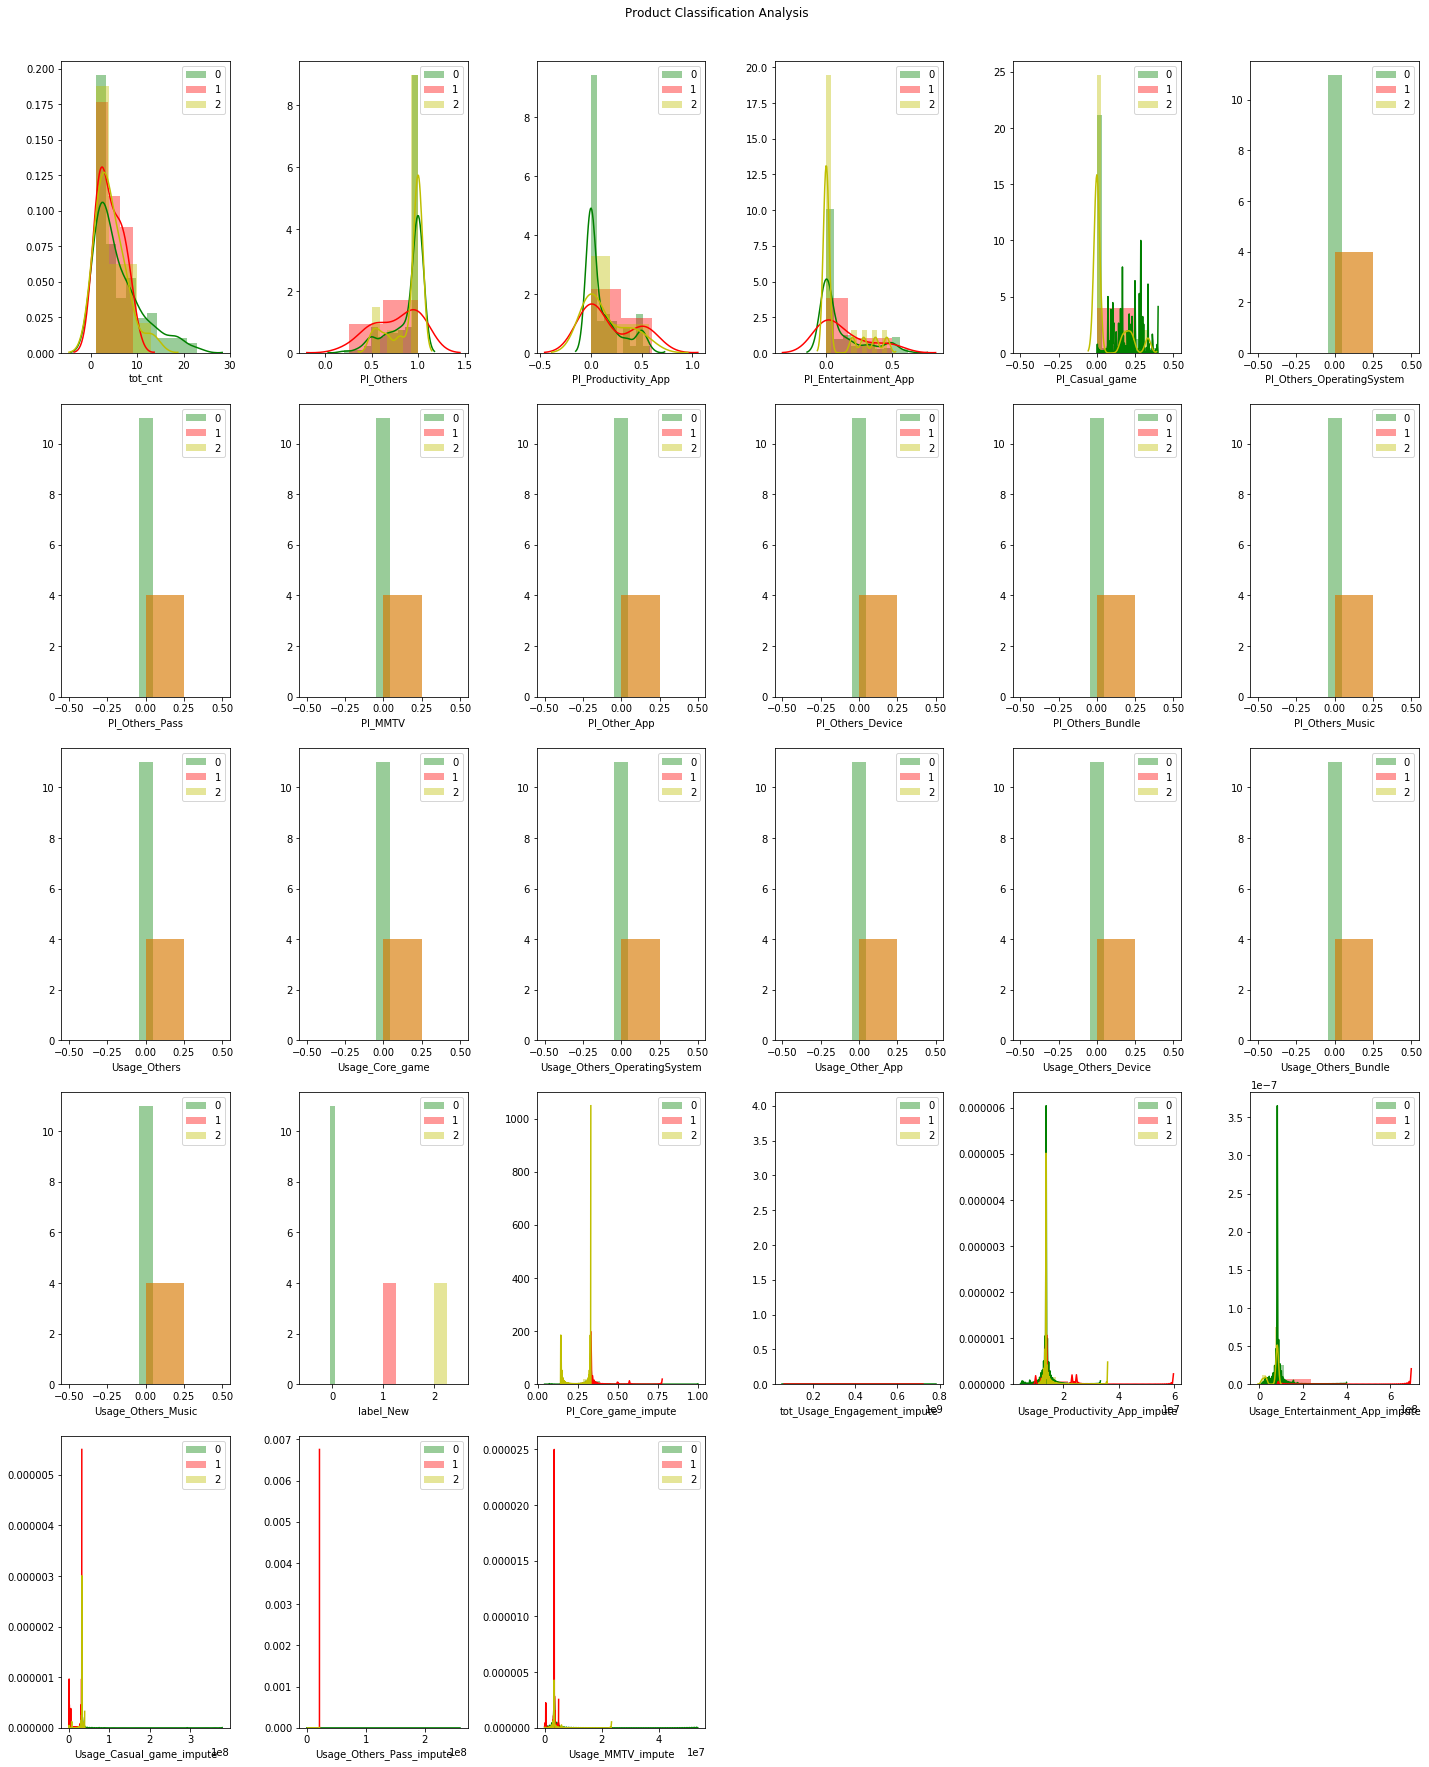

In [206]:
data_final_numeric = train.select(feat).toPandas()

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_final_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==0], color='g', label = '0')
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==1], color='r', label = '1')
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==2], color='y', label = '2')
    plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

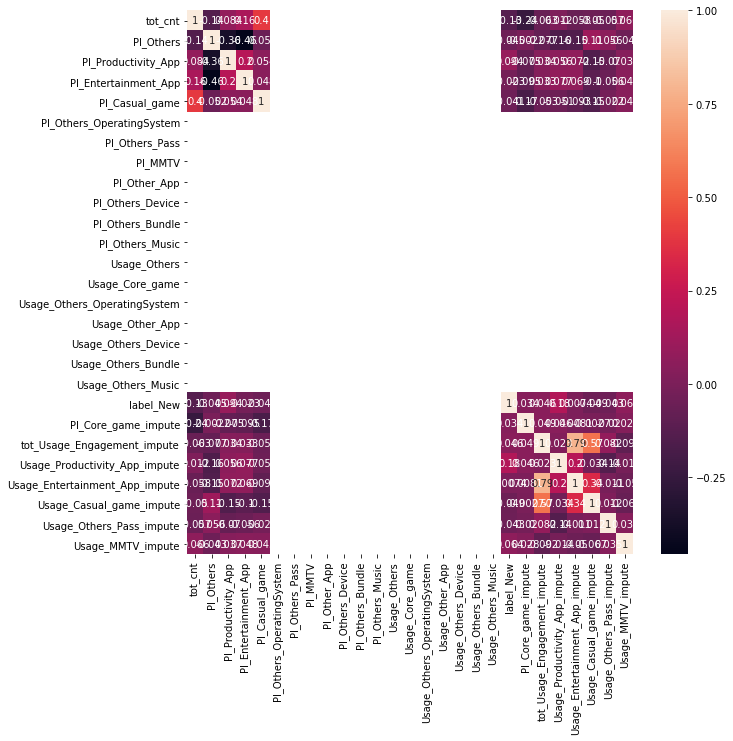

In [207]:
fig, ax = plt.subplots(figsize=(10,10))        
sns.heatmap(data_final_numeric.corr(), annot=True, ax=ax)

## 2.8 Feature selection - correlation and chi-squared test

In [208]:
len(data_final_numeric.columns)

27

In [209]:
# select features where correlation < 0.9
corr = data_final_numeric.corr() 

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9 or corr.iloc[i,j] <= -0.9:
            if columns[j]:
                columns[j] = False


selected_columns = data_final_numeric.columns[columns]
selected_columns

Index(['tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App',
       'PI_Casual_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass',
       'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle',
       'PI_Others_Music', 'Usage_Others', 'Usage_Core_game',
       'Usage_Others_OperatingSystem', 'Usage_Other_App',
       'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music',
       'label_New', 'PI_Core_game_impute', 'tot_Usage_Engagement_impute',
       'Usage_Productivity_App_impute', 'Usage_Entertainment_App_impute',
       'Usage_Casual_game_impute', 'Usage_Others_Pass_impute',
       'Usage_MMTV_impute'],
      dtype='object')

In [210]:
len(selected_columns)

27

In [ ]:
## all features are selected

## now try Feature selection using chisquareSelector

In [ ]:
## select values based on p-value, null-hypothesis says this combination of features does not affects the independent variable.
## if p-value < threshold then it affects the prediction and hence kept in feature set (i.e. reject the nul-hypothesis)
## 

In [212]:

from pyspark.ml.feature import ChiSqSelector
# css=ChiSqSelector().setFeaturesCol('Scaled_features').setLabelCol("Outcome").setOutputCol("Aspect")
css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect',labelCol='label_New',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                                                                                                                                                                   |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(26,[0,1,3,19,20,21,22,23,24,25],[0.6115136263596808,5.049385646318164,1.9566839747130724,3.9639414131542163,2.656250074793466,3.0022007802481343,1.5181864402012777,0.9554209175523588,1.182479818

## 3. Model Building

In [213]:
from pyspark.ml.classification import LogisticRegression
# lr = LogisticRegression().setWeightCol("classWeights").setLabelCol("Outcome").setFeaturesCol("Aspect")
lr = LogisticRegression(labelCol="label_New", featuresCol="Aspect",weightCol="classWeights",maxIter=10,family="multinomial")
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("label_New","prediction").show(10)

+---------+----------+
|label_New|prediction|
+---------+----------+
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       2.0|
|        2|       0.0|
|        0|       0.0|
|        0|       0.0|
|        1|       0.0|
|        1|       1.0|
|        0|       0.0|
+---------+----------+
only showing top 10 rows



## 4 Model evaluation

In [214]:
# The BinaryClassificationEvaluator uses areaUnderROC as the default metric. As o fnow we will continue with the same
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label_New")

In [215]:
predict_test.select("label_New","rawPrediction","prediction","probability").show(5)

+---------+--------------------+----------+--------------------+
|label_New|       rawPrediction|prediction|         probability|
+---------+--------------------+----------+--------------------+
|        0|[0.73823635752289...|       0.0|[0.59864959223490...|
|        0|[0.65904170089730...|       0.0|[0.56474391985098...|
|        0|[1.32041547794434...|       0.0|[0.54036656326967...|
|        0|[1.47122592443811...|       2.0|[0.44182325245128...|
|        2|[2.67139779794702...|       0.0|[0.96320140098523...|
+---------+--------------------+----------+--------------------+
only showing top 5 rows



In [216]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.6164335664335665
The area under ROC for test set is 0.5517241379310345


In [56]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: Aspect)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label_New)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. T

In [57]:

# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# paramGrid = ParamGridBuilder()\
#     .addGrid(lr.aggregationDepth,[2,5,10])\
#     .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
#     .addGrid(lr.fitIntercept,[False, True])\
#     .addGrid(lr.maxIter,[10, 100, 1000])\
#     .addGrid(lr.regParam,[0.01, 0.5, 2.0]) \
#     .build()

In [110]:
# # Create 5-fold CrossValidator
# cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# # Run cross validations
# cvModel = cv.fit(train)
# # this will likely take a fair amount of time because of the amount of models that we're creating and testing
# predict_train=cvModel.transform(train)
# predict_test=cvModel.transform(test)
# print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
# print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_test)))

In [218]:
print (predict_test.toPandas().head(5))

   AnonPuid  tot_cnt  PI_Others  PI_Productivity_App  PI_Entertainment_App  \
0         7        3      1.000             0.000000              0.333333   
1        10        8      0.875             0.125000              0.000000   
2        13        5      0.600             0.400000              0.000000   
3        25        5      1.000             0.000000              0.000000   
4        27       12      0.750             0.333333              0.250000   

   PI_Casual_game  PI_Others_OperatingSystem  PI_Others_Pass  PI_MMTV  \
0        0.000000                        0.0             0.0      0.0   
1        0.000000                        0.0             0.0      0.0   
2        0.000000                        0.0             0.0      0.0   
3        0.200000                        0.0             0.0      0.0   
4        0.083333                        0.0             0.0      0.0   

   PI_Other_App     ...      Usage_Entertainment_App_impute  \
0           0.0     ...      